# Face Recognition Training on LFW

Train a face recognition model to identify people by name using the LFW dataset.

In [1]:
import sys
sys.path.insert(0, '..')

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from pathlib import Path

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


## 1. Load LFW Dataset

In [2]:
from src.data.lfw import create_lfw_dataloaders
from src.data.transforms import get_train_transforms, get_val_transforms

# Configuration
LFW_ROOT = '../data'  # Path to LFW data
BATCH_SIZE = 64
IMAGE_SIZE = 224
MIN_IMAGES_PER_PERSON = 3 # Only include people with >= 3 images
MAX_PEOPLE = None  # Top 50 people with most images

# Create dataloaders
train_loader, val_loader, num_classes, class_names = create_lfw_dataloaders(
    root=LFW_ROOT,
    batch_size=BATCH_SIZE,
    min_images_per_person=MIN_IMAGES_PER_PERSON,
    max_people=MAX_PEOPLE,
    transform_train=get_train_transforms(IMAGE_SIZE),
    transform_val=get_val_transforms(IMAGE_SIZE)
)

print(f'\nTraining samples: {len(train_loader.dataset)}')
print(f'Validation samples: {len(val_loader.dataset)}')
print(f'Number of people: {num_classes}')
print(f'\nPeople in dataset:')
for i, name in enumerate(class_names[:10]):
    print(f'  {i}: {name}')
print('  ...')

LFW train: 6084 images, 901 people
LFW val: 1522 images, 901 people

Training samples: 6084
Validation samples: 1522
Number of people: 901

People in dataset:
  0: Aaron_Peirsol
  1: Abdoulaye_Wade
  2: Abdullah
  3: Abdullah_Gul
  4: Abdullah_al-Attiyah
  5: Abel_Pacheco
  6: Abid_Hamid_Mahmud_Al-Tikriti
  7: Adam_Sandler
  8: Adel_Al-Jubeir
  9: Adolfo_Aguilar_Zinser
  ...


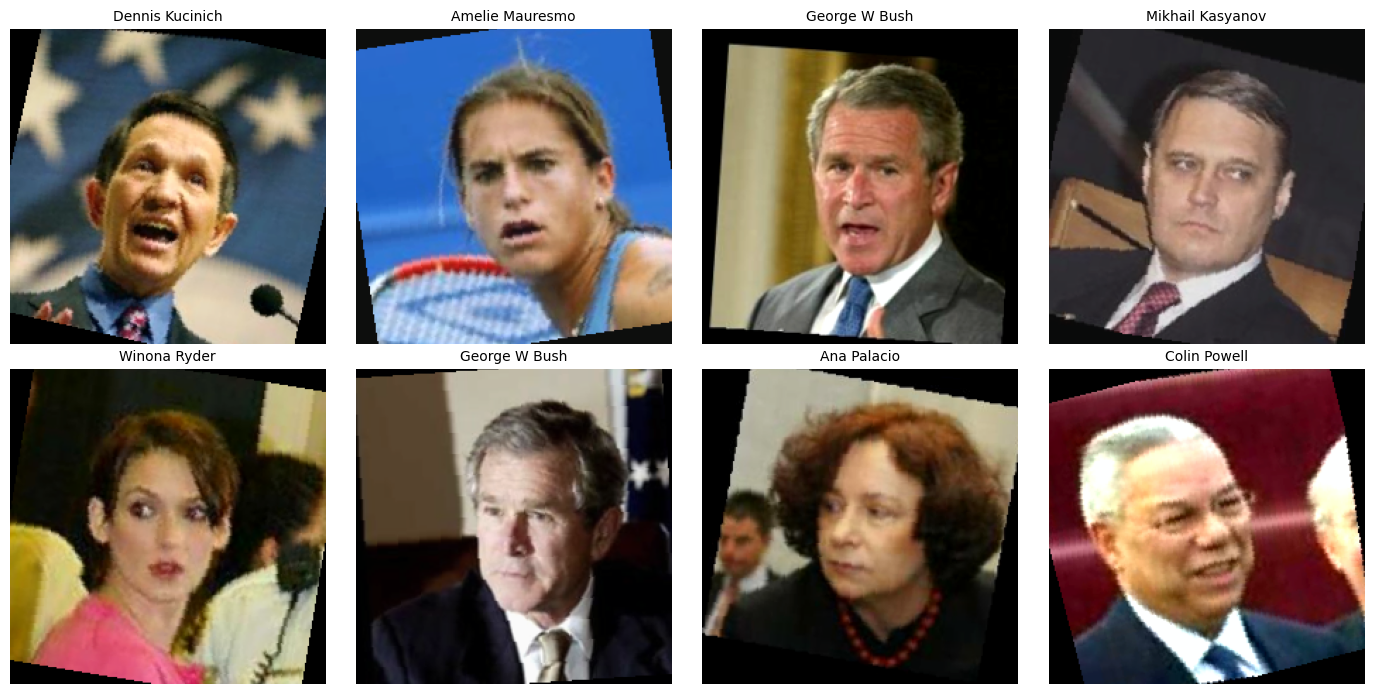

In [3]:
# Visualize some samples
def show_batch(loader, class_names, n=8):
    images, labels = next(iter(loader))
    
    fig, axes = plt.subplots(2, 4, figsize=(14, 7))
    for i, ax in enumerate(axes.flat):
        if i >= n:
            break
        img = images[i].permute(1, 2, 0).numpy()
        # Denormalize
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        img = img.clip(0, 1)
        ax.imshow(img)
        ax.set_title(class_names[labels[i].item()].replace('_', ' '), fontsize=10)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

show_batch(train_loader, class_names)

## 2. Create Model

In [4]:
from src.models.classifier import FaceClassifier

model = FaceClassifier(
    num_classes=num_classes,
    backbone='resnet50',  # Options: resnet50, efficientnet_b0, mobilenetv3_small_100
    pretrained=True,
    dropout=0.5
).to(device)

print(f'Parameters: {sum(p.numel() for p in model.parameters()):,}')

Parameters: 25,019,333


## 3. Training

In [5]:
from src.training.trainer import Trainer

# Training config
EPOCHS = 7
LR = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

trainer = Trainer(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    mixed_precision=True
)

c:\Users\salah\Documents\MASTER\DL\ProjectV2\notebooks\..\src\training\trainer.py:33: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler() if mixed_precision else None


In [6]:
# Train!
history = trainer.fit(
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    save_dir='../models/checkpoints'
)


Epoch 1/7
----------------------------------------


Training:   0%|          | 0/96 [00:00<?, ?it/s]c:\Users\salah\Documents\MASTER\DL\ProjectV2\notebooks\..\src\training\trainer.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 24/24 [00:19<00:00,  1.21it/s]


Train Loss: 6.1720 | Train Acc: 6.97%
Val Loss: 5.8934 | Val Acc: 6.83%
[OK] Saved best model

Epoch 2/7
----------------------------------------


Validation: 100%|██████████| 24/24 [00:19<00:00,  1.24it/s]


Train Loss: 5.4834 | Train Acc: 13.54%
Val Loss: 5.1766 | Val Acc: 17.61%
[OK] Saved best model

Epoch 3/7
----------------------------------------


Validation: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


Train Loss: 4.6429 | Train Acc: 23.32%
Val Loss: 4.3108 | Val Acc: 28.45%
[OK] Saved best model

Epoch 4/7
----------------------------------------


Validation: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


Train Loss: 3.7775 | Train Acc: 32.10%
Val Loss: 3.7103 | Val Acc: 35.81%
[OK] Saved best model

Epoch 5/7
----------------------------------------


Validation: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


Train Loss: 3.0526 | Train Acc: 40.15%
Val Loss: 3.1841 | Val Acc: 43.50%
[OK] Saved best model

Epoch 6/7
----------------------------------------


Validation: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


Train Loss: 2.5195 | Train Acc: 47.22%
Val Loss: 2.9674 | Val Acc: 47.70%
[OK] Saved best model

Epoch 7/7
----------------------------------------


Validation: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


Train Loss: 2.2407 | Train Acc: 52.33%
Val Loss: 2.9077 | Val Acc: 48.95%
[OK] Saved best model


## 4. Evaluate Results

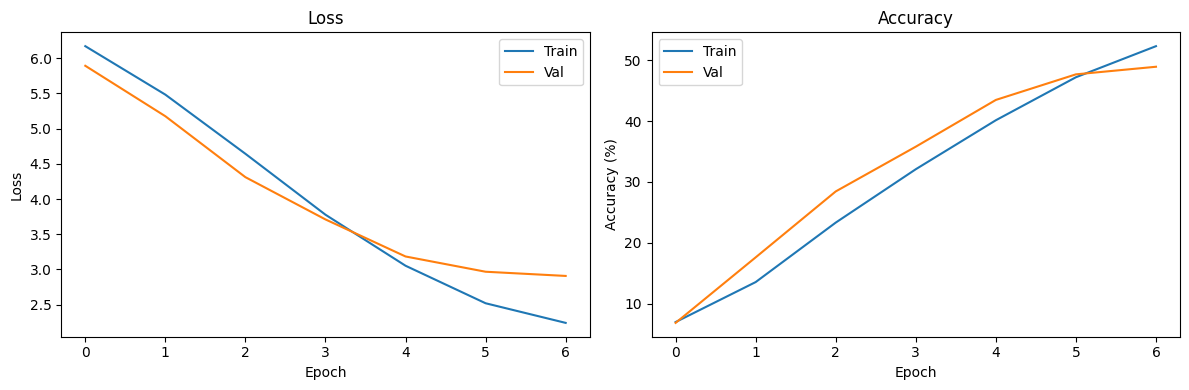

In [7]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history['train_loss'], label='Train')
axes[0].plot(history['val_loss'], label='Val')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(history['train_acc'], label='Train')
axes[1].plot(history['val_acc'], label='Val')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend()
axes[1].set_title('Accuracy')

plt.tight_layout()
plt.savefig('../outputs/training_curves.png', dpi=150)
plt.show()

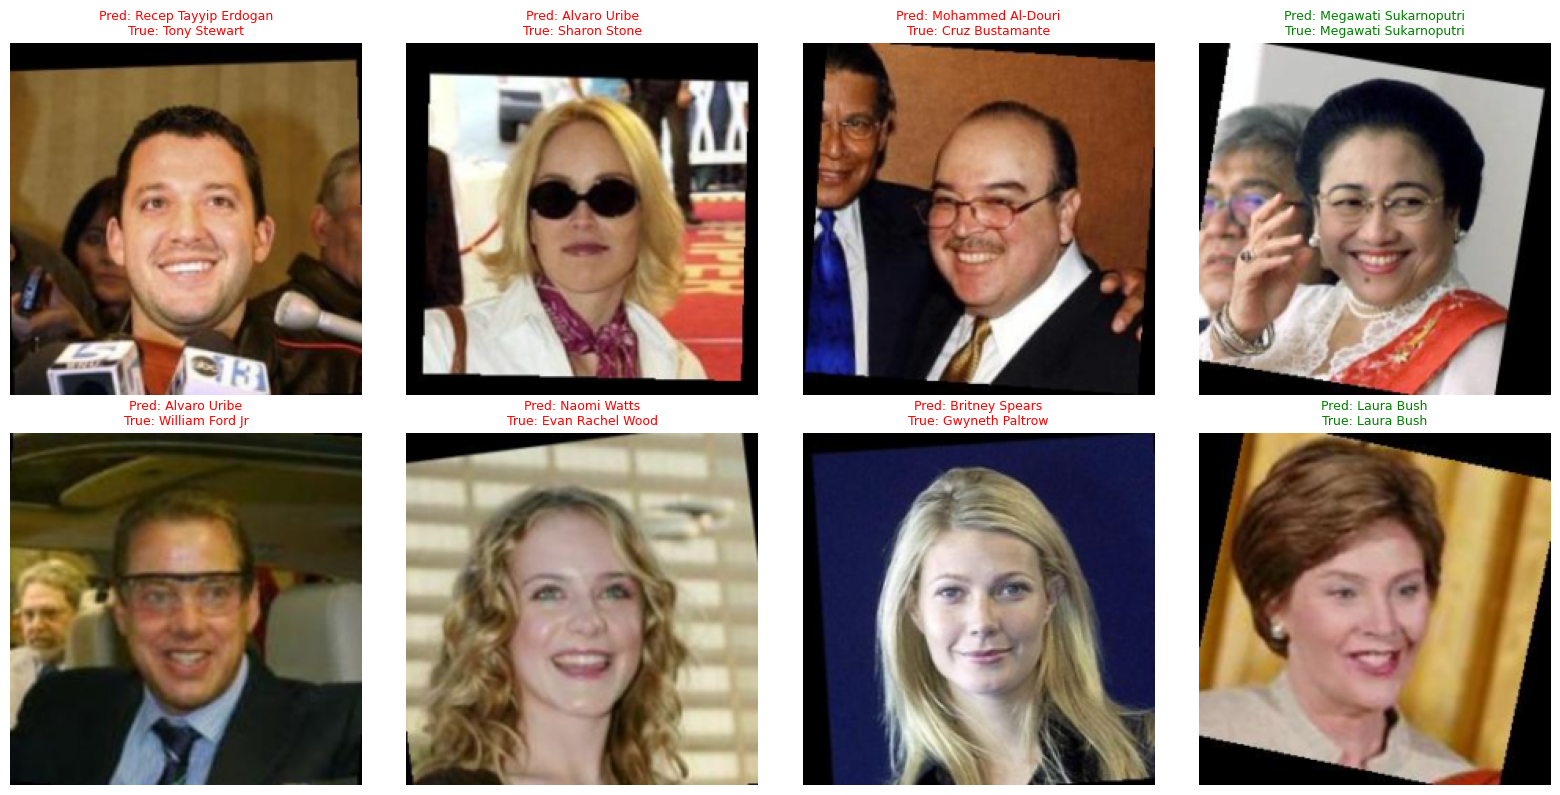

In [8]:
# Test predictions
model.eval()
images, labels = next(iter(val_loader))
images = images.to(device)

preds, probs = model.predict(images)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i, ax in enumerate(axes.flat):
    img = images[i].cpu().permute(1, 2, 0).numpy()
    img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    img = img.clip(0, 1)
    
    ax.imshow(img)
    pred_name = class_names[preds[i].item()].replace('_', ' ')
    true_name = class_names[labels[i].item()].replace('_', ' ')
    color = 'green' if preds[i].item() == labels[i].item() else 'red'
    ax.set_title(f'Pred: {pred_name}\nTrue: {true_name}', color=color, fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()

## 5. Save Model for Inference

In [9]:
import json

# Save model with class names
save_dict = {
    'model_state_dict': model.state_dict(),
    'num_classes': num_classes,
    'class_names': class_names,
    'backbone': 'resnet50'
}

torch.save(save_dict, '../models/checkpoints/face_recognition.pt')

# Also save class names as JSON for easy loading
with open('../models/checkpoints/class_names.json', 'w') as f:
    json.dump(class_names, f, indent=2)

print('Model and class names saved!')

Model and class names saved!
